In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import pickle


In [2]:
df = pd.read_excel(r"C:\Users\ASUS\Downloads\Book (2).xlsx")
df.head()


,ID,Comment (Malayalam),English Translation,Company,Sentiment,Improvement needed
0,1,ഈ ലിപ്സ്റ്റിക് സൂപ്പർ ആണ്! കളർ നീണ്ടുനിൽക്ുും.,This lipstick is amazing! The color lasts long.,Lakme,Positive,NaN
1,2,ഈ ഫൗണ്ടണ്ടഷൻ മുഖും വരണ്ടതാക്ുന്നു.,This foundation makes the face dry.,Lakme,Negative,Quality
2,3,"ഗുഡ് കകീും, പണ്ടേ വില കൂടുതലാണ്.","Good cream, but the price is high.",Nivea,Neutral,Price
3,4,എന്റെ സ്കിനിന് ഇത് റപാരുത്തറപ്പടുന്നിലല.,This doesn’t suit my skin.,L'Oréal,Negative,Product Availability
4,5,ണ്ടേർത്ത് പിടിച്ചു നിൽക്ുന്ന മസ്കാര.,Long-lasting mascara.,Maybelline,Positive,NaN


In [3]:
df.shape

(200, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   200 non-null    int64 
 1   Comment (Malayalam)  200 non-null    object
 2   English Translation  200 non-null    object
 3   Company              200 non-null    object
 4   Sentiment            200 non-null    object
 5   Improvement needed   140 non-null    object
dtypes: int64(1), object(5)
memory usage: 9.5+ KB


In [5]:
df.isnull().sum()

ID                      0
Comment (Malayalam)     0
English Translation     0
Company                 0
Sentiment               0
Improvement needed     60
dtype: int64

In [6]:
df['Improvement needed'] = df['Improvement needed'].fillna('Unknown')

df.isnull().sum()

ID                     0
Comment (Malayalam)    0
English Translation    0
Company                0
Sentiment              0
Improvement needed     0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.columns

Index(['ID', 'Comment (Malayalam)', 'English Translation', 'Company',
       'Sentiment', 'Improvement needed'],
      dtype='object')

In [9]:
cat_clm=['Company',
       'Sentiment', 'Improvement needed']
for col in cat_clm:
    print(f"Unique values in {col} : {df[col].unique()}")

Unique values in Company : ['Lakme' 'Nivea' "L'Oréal" 'Maybelline' 'Himalaya' 'Sunsilk' 'Plum'
 'Insight' 'plum']
Unique values in Sentiment : ['Positive' 'Negative' 'Neutral']
Unique values in Improvement needed : ['Unknown' 'Quality' 'Price' 'Product Availability' 'Fragrance'
 'Packaging' 'Quantity Issue']


In [10]:
df['Company'] = df['Company'].replace('plum', 'Plum')

df.to_excel("updated_file.xlsx", index=False, engine="openpyxl")

print(df['Company'].unique())

['Lakme' 'Nivea' "L'Oréal" 'Maybelline' 'Himalaya' 'Sunsilk' 'Plum'
 'Insight']


In [11]:
df.drop(columns=['ID', 'English Translation', 'Company'],inplace=True)
df.head()

,Comment (Malayalam),Sentiment,Improvement needed
0,ഈ ലിപ്സ്റ്റിക് സൂപ്പർ ആണ്! കളർ നീണ്ടുനിൽക്ുും.,Positive,Unknown
1,ഈ ഫൗണ്ടണ്ടഷൻ മുഖും വരണ്ടതാക്ുന്നു.,Negative,Quality
2,"ഗുഡ് കകീും, പണ്ടേ വില കൂടുതലാണ്.",Neutral,Price
3,എന്റെ സ്കിനിന് ഇത് റപാരുത്തറപ്പടുന്നിലല.,Negative,Product Availability
4,ണ്ടേർത്ത് പിടിച്ചു നിൽക്ുന്ന മസ്കാര.,Positive,Unknown


Text(0.5, 1.0, 'countplot of sentiment')

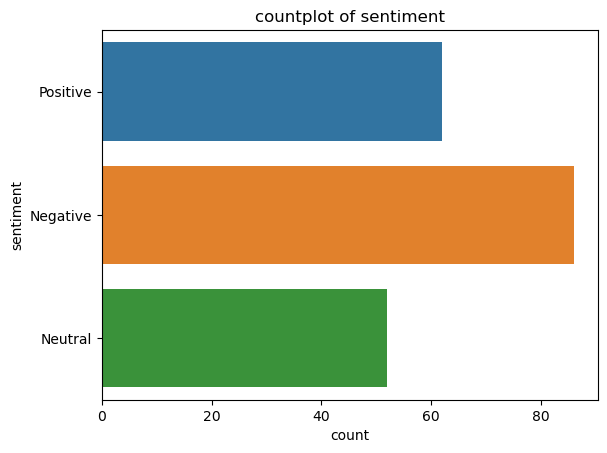

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(df,y='Sentiment',hue='Sentiment')
plt.ylabel('sentiment')
plt.title('countplot of sentiment')

In [13]:
'''import nltk

nltk.download('stopwords')
nltk.download('punkt_tab')
'''

"import nltk\n\nnltk.download('stopwords')\nnltk.download('punkt_tab')\n"

In [14]:
from nltk.corpus import stopwords
stopwords.fileids()  # Check available languages


['albanian',
 'arabic',
 'azerbaijani',
 'basque',
 'belarusian',
 'bengali',
 'catalan',
 'chinese',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'greek',
 'hebrew',
 'hinglish',
 'hungarian',
 'indonesian',
 'italian',
 'kazakh',
 'nepali',
 'norwegian',
 'portuguese',
 'romanian',
 'russian',
 'slovene',
 'spanish',
 'swedish',
 'tajik',
 'turkish']

In [15]:
malayalam_stopwords = [
    "ആണ്", "അല്ല", "എന്ന", "എന്നാൽ", "അവൻ", "അവൾ", "അവർ", "ഞാൻ", "നിന്റെ", "നിങ്ങളുടെ", 
    "നമ്മുടെ", "അവന്റെ", "അവളുടെ", "അവരുടെ", "എന്റെ", "ഇത്", "അതു", "ആ", "ഇവ", "അവ", 
    "ഇവൻ", "ഇവൾ", "ഇവർ", "അവൻ", "അവൾ", "അവർ", "അതിന്റെ", "ഇതിനുള്ള", "അതിനുള്ള", 
    "അവിടേയ്ക്ക്", "ഇവിടേയ്ക്ക്", "എവിടേയ്ക്ക്", "എവിടും", "ഇവിടും", "അവിടും", 
    "ഇപ്പോൾ", "അപ്പോൾ", "എപ്പോഴാണ്", "എപ്പോൾ", "എത്ര", "എത്രത്തോളം", "എത്രമാത്രം", 
    "എവിടെയാണ്", "എവിടെയാണ്", "എവിടുന്ന്", "എവിടെ", "എങ്ങനെയാണ്", "എന്ത്", "എന്താണ്", 
    "എന്തിനാണ്", "എന്തിനാണ്", "കാണാം", "കാണുന്നു", "കാണുന്ന", "കാണാത്ത", "കണ്ടു", "കണ്ട", 
    "കണ്ടുപിടിക്കാം", "കണ്ടുപിടിച്ചു", "കണ്ടുപിടിച്ച", "കണ്ടുപിടിക്കുന്നത്", "കണ്ടുപിടിക്കേണ്ടത്", 
    "കണ്ടുപിടിക്കണം", "കണ്ടുപിടിക്കുകയോ", "കണ്ടുപിടിക്കുകയല്ല", "കണ്ടുപിടിക്കേണ്ട", "ആകുന്നു", 
    "ആയി", "ആയിരിക്കും", "ആയിരുന്നു", "ആകുന്നത്", "ആകാനാണ്", "ആകണ്ട", "ആകേണ്ടത്", "ആകാൻ", 
    "ആകാം", "ആകുന്ന", "ചെയ്യുന്നു", "ചെയ്യുന്നു", "ചെയ്ത", "ചെയ്തത്", "ചെയ്താൽ", "ചെയ്യേണ്ട", 
    "ചെയ്യണം", "ചെയ്യാനാണ്", "ചെയ്യേണ്ടത്", "ഉണ്ടോ", "ഉണ്ടാവും", "ഉണ്ടായിരുന്നു", "ഉണ്ടായിരുന്ന", 
    "ഉണ്ടായിരിക്കുക", "ഉണ്ടായിരിക്കുകയോ", "ഉണ്ടായിരുന്നില്ല", "ഉണ്ടാകുന്ന", "ഉണ്ടാകാത്ത", 
    "ഉണ്ടാവുന്നതും", "ഉണ്ടാവില്ല", "ഉണ്ടാകുന്നു", "ഉണ്ടാകേണ്ട", "ഉണ്ടാകണം", "ഉണ്ടാകേണ്ടത്", "ഉണ്ടാകുന്നത്"
]


def preprocess_text(text):
    
    text = re.sub(r"[^അ-ഹ0-9\s]", "",text)   # Remove punctuation
    words = text.split()
    words = [word for word in words if word not in malayalam_stopwords]  # Remove stopwords
    return ' '.join(words)

df['processed_text'] = df['Comment (Malayalam)'].apply(preprocess_text)


In [16]:
df.head()

,Comment (Malayalam),Sentiment,Improvement needed,processed_text
0,ഈ ലിപ്സ്റ്റിക് സൂപ്പർ ആണ്! കളർ നീണ്ടുനിൽക്ുും.,Positive,Unknown,ഈ ലപസററക സപപ ആണ കള നണടനക
1,ഈ ഫൗണ്ടണ്ടഷൻ മുഖും വരണ്ടതാക്ുന്നു.,Negative,Quality,ഈ ഫണടണടഷ മഖ വരണടതകനന
2,"ഗുഡ് കകീും, പണ്ടേ വില കൂടുതലാണ്.",Neutral,Price,ഗഡ കക പണട വല കടതലണ
3,എന്റെ സ്കിനിന് ഇത് റപാരുത്തറപ്പടുന്നിലല.,Negative,Product Availability,എനറ സകനന ഇത റപരതതറപപടനനലല
4,ണ്ടേർത്ത് പിടിച്ചു നിൽക്ുന്ന മസ്കാര.,Positive,Unknown,ണടതത പടചച നകനന മസകര


In [17]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['Sentiment'])  # 0: Negative, 1: Neutral, 2: Positive


In [18]:
one_hot_encoder = OneHotEncoder()
improvement_encoded = one_hot_encoder.fit_transform(df[['Improvement needed']]).toarray()


In [54]:
improvement_encoded

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [19]:
df.head()

,Comment (Malayalam),Sentiment,Improvement needed,processed_text,sentiment_encoded
0,ഈ ലിപ്സ്റ്റിക് സൂപ്പർ ആണ്! കളർ നീണ്ടുനിൽക്ുും.,Positive,Unknown,ഈ ലപസററക സപപ ആണ കള നണടനക,2
1,ഈ ഫൗണ്ടണ്ടഷൻ മുഖും വരണ്ടതാക്ുന്നു.,Negative,Quality,ഈ ഫണടണടഷ മഖ വരണടതകനന,0
2,"ഗുഡ് കകീും, പണ്ടേ വില കൂടുതലാണ്.",Neutral,Price,ഗഡ കക പണട വല കടതലണ,1
3,എന്റെ സ്കിനിന് ഇത് റപാരുത്തറപ്പടുന്നിലല.,Negative,Product Availability,എനറ സകനന ഇത റപരതതറപപടനനലല,0
4,ണ്ടേർത്ത് പിടിച്ചു നിൽക്ുന്ന മസ്കാര.,Positive,Unknown,ണടതത പടചച നകനന മസകര,2


In [20]:
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['sentiment_encoded'], test_size=0.2, random_state=42)
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(df['processed_text'], improvement_encoded, test_size=0.2, random_state=42)

 #### Random Forest Model for Sentiment Analysis

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text into TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Evaluate
y_pred_rf = rf_model.predict(X_test_tfidf)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

# Save model
pickle.dump(rf_model, open("rf_model.pkl", "wb"))
pickle.dump(tfidf, open("tfidf.pkl", "wb"))


Random Forest Accuracy: 0.75


#### LSTM Model for Sentiment Analysis

In [24]:
# Tokenization for LSTM
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)

# LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(3, activation='softmax')  # 3 classes: Positive, Neutral, Negative
])

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test), epochs=5, batch_size=32)

# Evaluate
_, lstm_accuracy = lstm_model.evaluate(X_test_seq, y_test)
print("LSTM Accuracy:", lstm_accuracy)

# Save model
lstm_model.save("lstm_model.h5")
pickle.dump(tokenizer, open("tokenizer.pkl", "wb"))


Epoch 1/5


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.3627 - loss: 1.1003 - val_accuracy: 0.4500 - val_loss: 1.0852
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3656 - loss: 1.0777 - val_accuracy: 0.4500 - val_loss: 1.0611
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4594 - loss: 1.0483 - val_accuracy: 0.4500 - val_loss: 1.0491
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4398 - loss: 1.0412 - val_accuracy: 0.4500 - val_loss: 1.0348
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4432 - loss: 1.0157 - val_accuracy: 0.4500 - val_loss: 1.0248
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4250 - loss: 1.0338


LSTM Accuracy: 0.44999998807907104


In [25]:
#### Train Random Forest for Improvement Needed

In [26]:
X_train_tfidf_imp = tfidf.transform(X_train_imp)
X_test_tfidf_imp = tfidf.transform(X_test_imp)

# Train Random Forest for improvement prediction
rf_model_imp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_imp.fit(X_train_tfidf_imp, y_train_imp)


# Check accuracy for Random Forest Improvement Model
y_pred_rf_imp = rf_model_imp.predict(X_test_tfidf_imp)
improvement_accuracy = accuracy_score(y_test_imp.argmax(axis=1), y_pred_rf_imp.argmax(axis=1))
print("Random Forest Improvement Prediction Accuracy:", improvement_accuracy)

# Save model
pickle.dump(rf_model_imp, open("rf_model_imp.pkl", "wb"))


Random Forest Improvement Prediction Accuracy: 0.525


In [27]:
def predict_comment(comment):
    comment_processed = preprocess_text(comment)
    comment_tfidf = tfidf.transform([comment_processed])
    
    # Sentiment Prediction
    sentiment_pred_rf = rf_model.predict(comment_tfidf)[0]
    sentiment_text = label_encoder.inverse_transform([sentiment_pred_rf])[0]
    
    # If sentiment is positive
    if sentiment_text == "Positive":
        return f"Sentiment: {sentiment_text}. Customer is satisfied, no improvement needed."
    
    # Improvement Prediction
    improvement_pred = rf_model_imp.predict(comment_tfidf)[0]
    improvements = one_hot_encoder.inverse_transform([improvement_pred])[0][0]
    
    return f"Sentiment: {sentiment_text}. Suggested improvement: {improvements}."

# Example usage
print(predict_comment("ഗുഡ് കകീും, പണ്ടേ വില കൂടുതലാണ്."))


Sentiment: Neutral. Suggested improvement: Price.
